# Results of the trained Transformer on Gissinger system

In [5]:
from trphysx.embedding.embedding_gissinger import GissingerEmbedding
from trphysx.transformer.phys_transformer_gpt2 import PhysformerGPT2
from trphysx.config.configuration_gissinger import GissingerConfig

import torch
import h5py
import numpy as np
from scipy.integrate import odeint
import os
import matplotlib.pyplot as plt
%matplotlib inline

### Embedder and Transformer files

In [6]:
emb_state_dir = "./outputs/embedding_gissinger/ntrain2048_epochs200_batch512/checkpoints"
emb_state_file ="/embedding_gissinger200.pth"

trans_state_dir = "./outputs/transformer_gissinger/ntrain2048_epochs300_batch32/checkpoints"
trans_state_file = "/transformer_gissinger200.pth"


### Loading embedder and transformer model

In [7]:
conf = GissingerConfig()

emb = GissingerEmbedding(conf,)
emb.load_state_dict(torch.load(emb_state_dir + emb_state_file))

trans = PhysformerGPT2(conf,"pretrained")
trans.load_state_dict(
    torch.load(trans_state_dir + trans_state_file)
)
trans.eval()
emb.eval()

GissingerEmbedding(
  (observableNet): Sequential(
    (0): Linear(in_features=3, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=32, bias=True)
    (3): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (4): Dropout(p=0.0, inplace=False)
  )
  (recoveryNet): Sequential(
    (0): Linear(in_features=32, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=3, bias=True)
  )
)

### Helper function for generating trajectories

In [8]:
def gissinger(state,t,mu=0.119,nu=0.1,gamma=0.9):
    """
    Differential equation defining the gissinger
    system - passed to odeint
    Args:
    state: (Q,D,V) dynamic variables of the system
    t: time variable
    parameters:
    mu,nu,gamma
    Returns:
    derivateives of Q,D and V in time.
    """
    Q,D,V = state
    dQ = mu*Q - V*D
    dD = -nu*D + V*Q
    dV = gamma - V + Q*D
    return dQ,dD,dV

### Functions for making comparison plots

In [9]:
def comparison_plot3d(transf,embedder,t=np.arange(0,50,0.03),n_curves=3,seed = None):
    if seed is not None:
        np.random.seed(seed)
    N = len(t)
    transf.eval()
    embedder.eval()
    ax = plt.figure().add_subplot(projection = "3d")
    for i in range(n_curves):
        initial = np.random.uniform(-2.3,2.3,size = (3))
        real = odeint(gissinger,initial,t)
        #ax.scatter(real[::5,0],real[::5,1],real[::5,2],s = 15)
        ax.plot(real[:,0],real[:,1],real[:,2],label = "real")
        with torch.no_grad():
            initial = embedder(torch.tensor(initial,dtype = torch.float32))[0].view(1,1,32)
            pred = embedder.recover(
                transf.generate(initial,max_length = N)[0]).detach().numpy().reshape(-1,3)
        ax.plot(pred[:,0],pred[:,1],pred[:,2],label = "predicted")
    ax.legend(fontsize = 8)
    ax.set_xlabel("Q")
    ax.set_ylabel("D")
    ax.set_zlabel("V")

    return ax

def comparison_plot(transf,embedder,t=np.arange(0,50,0.03),n_curves=3,seed = None):
    variable = ["Q","D","V"]
    if seed is not None:
        np.random.seed(seed)
    N = len(t)
    transf.eval()
    embedder.eval()
    frame,fig = plt.subplots(3,1,)
    for i in range(n_curves):
        initial = np.random.uniform(-2.3,2.3,size = (3))
        real = odeint(gissinger,initial,t)
        #ax.scatter(real[::5,0],real[::5,1],real[::5,2],s = 15)
        for j in range(3):
            fig[j].plot(t,real[:,j],label ="real")
        with torch.no_grad():
            initial = embedder(torch.tensor(initial,dtype = torch.float32))[0].view(1,1,32)
            pred = embedder.recover(
                transf.generate(initial,max_length = N)[0]).detach().numpy().reshape(-1,3)
        for j in range(3):
            fig[j].plot(t,pred[:,j],label ="predicted")
            fig[j].set_ylabel(variable[j])
            fig[j].legend(fontsize = 8)
    return fig


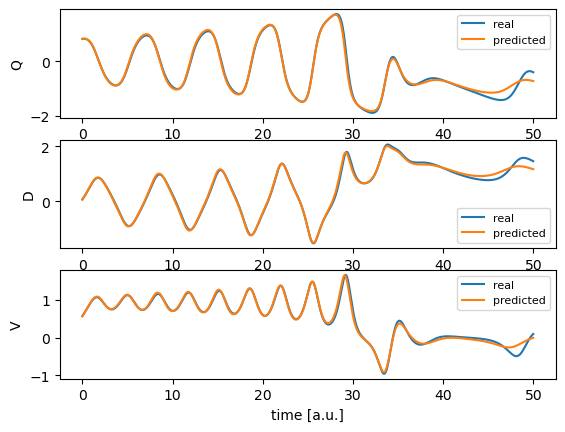

In [10]:
#Succesful seeds: 1,112, 120, 1001, 89, 2211,93 - Predictions lose accuray later 
#Unsuccesful seeds: 69,619 6969,365,22111997 - Predictions lose accuray sooner
seed = 120
fig_comp = comparison_plot(trans,emb,n_curves=1,seed = seed)
fig_comp[2].set_xlabel("time [a.u.]")
plt.savefig("comparison.png")

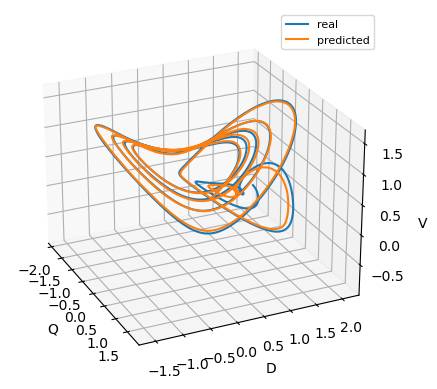

In [12]:
fig_comp3d = comparison_plot3d(trans,emb,n_curves=1,seed = seed)
fig_comp3d.view_init(elev=25, azim=-25,)
plt.savefig("comparison.png")